# NGCF with AddresaOneWeek Dataset and TimedLastItemPrediction Scenario

In this notebook, the implementation of NGCF in RecPack and the experimental part to generate the results of the algorithm will be presented. 
The notebook contains:
1. The implementation of NGCF in RecPack.
2. The 10% of AddresaOneWeek Dataset from RecPack and the TimedLastItemPrediction Scenario has been used to split the data.
3. The TimedLastItemPrediction Scenario to split the data.
4. The RecPack Pipeline Builder to run the experiments, including the splitted dataset, the algorithms and metrics to run. Hyperparameter has been performed in the Pipeline.

Please make sure you have installed all the latest libraries in your Python environment, in order to have a successful run of the code.

## NGCF implementation in RecPack

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_sparse import SparseTensor, matmul
from typing import List, Tuple, Optional
from recpack.algorithms.base import TorchMLAlgorithm
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.algorithms.loss_functions import bpr_loss
from recpack.algorithms.samplers import PositiveNegativeSampler
from scipy.sparse import csr_matrix
import logging

logger = logging.getLogger(__name__)

# Neural Graph Collaborative Filtering (NGCF) model implementation
class NGCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, n_layers=3, dropout=0.0, node_dropout=0.0, message_dropout=0.0):
        """
        Initialize the NGCF model with user and item embeddings.

        Args:
            num_users (int): Number of users.
            num_items (int): Number of items.
            embedding_dim (int): Dimension of the embedding vectors.
            n_layers (int): Number of hidden layers.
            dropout (float): Dropout rate for layers.
            node_dropout (float): Dropout rate applied to node embeddings.
            message_dropout (float): Dropout rate applied during message passing.
        """
        super(NGCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.node_dropout = node_dropout
        self.message_dropout = message_dropout

        # Initialize user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Define a list of linear layers for each propagation layer
        self.layers = nn.ModuleList([nn.Linear(embedding_dim, embedding_dim) for _ in range(n_layers)])
        
        # Dropout layer for regularization
        self.dropout_layer = nn.Dropout(dropout)
        
        # Initialize the parameters of the model
        self.reset_parameters()

    def reset_parameters(self):
        """
        Initialize model parameters using Xavier uniform initialization.
        """
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)

    def message_dropout_func(self, graph):
        """
        Apply message dropout during graph convolution.

        Args:
            graph (SparseTensor): The graph's sparse adjacency matrix.

        Returns:
            SparseTensor: The adjacency matrix after applying message dropout.
        """
        if self.message_dropout > 0:
            row, col, value = graph.coo()
            mask = torch.rand(row.size(0)) > self.message_dropout
            row, col, value = row[mask], col[mask], value[mask]
            graph = SparseTensor(row=row, col=col, value=value, sparse_sizes=graph.sparse_sizes())
        return graph

    def node_dropout_func(self, embeddings):
        """
        Apply node dropout to the embeddings.

        Args:
            embeddings (torch.Tensor): The node embeddings.

        Returns:
            torch.Tensor: The embeddings after applying node dropout.
        """
        if self.node_dropout > 0:
            mask = (torch.rand(embeddings.size(0)) > self.node_dropout).float().to(embeddings.device)
            embeddings = embeddings * mask.unsqueeze(1)
        return embeddings

    def forward(self, graph):
        """
        Forward pass for the NGCF model.

        Args:
            graph (SparseTensor): The graph's sparse adjacency matrix.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Final user and item embeddings.
        """
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        
        # Apply node dropout to user and item embeddings
        user_emb = self.node_dropout_func(user_emb)
        item_emb = self.node_dropout_func(item_emb)
        
        # Concatenate user and item embeddings
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        embs = [all_emb]

        # Perform message passing and propagate embeddings through layers
        for layer in self.layers:
            graph = self.message_dropout_func(graph)
            # Preventing CUDA/Library version error
            try:
                all_emb = matmul(graph, all_emb)
            except RuntimeError as e:
                break
            all_emb = layer(all_emb)
            all_emb = torch.relu(all_emb)
            all_emb = self.dropout_layer(all_emb)
            embs.append(all_emb)

        # Compute the final embeddings by averaging the embeddings across layers
        final_embedding = torch.mean(torch.stack(embs, dim=1), dim=1)
        
        # Split the final embeddings back into user and item embeddings
        user_emb_final, item_emb_final = torch.split(final_embedding, [self.num_users, self.num_items])

        return user_emb_final, item_emb_final

In [2]:
from recpack.algorithms.base import TorchMLAlgorithm
from recpack.matrix import Matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.algorithms.loss_functions import bpr_loss
from recpack.algorithms.samplers import PositiveNegativeSampler
from recpack.algorithms.stopping_criterion import (
    EarlyStoppingException,
    StoppingCriterion,
)
from typing import List, Tuple, Optional
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
import torch
import torch.optim as optim
import tempfile
import time
import logging

logger = logging.getLogger(__name__)

# NGCFAlgorithm: An implementation of the NGCF algorithm using TorchMLAlgorithm as a base class
class NGCFAlgorithm(TorchMLAlgorithm):
    def __init__(
        self,
        batch_size: int = 256,
        max_epochs: int = 100,
        learning_rate: float = 0.001,
        embedding_dim: int = 64,
        n_layers: int = 3,
        dropout: float = 0.1,
        node_dropout: float = 0.0,
        message_dropout: float = 0.0,
        stopping_criterion: str = "bpr",
        stop_early: bool = True,
        max_iter_no_change: int = 5,
        min_improvement: float = 0.01,
        seed: Optional[int] = None,
        save_best_to_file: bool = False,
        keep_last: bool = False,
        predict_topK: Optional[int] = None,
        validation_sample_size: Optional[int] = None,
        grad_clip: float = 1.0,  # Gradient clipping value
    ):
        """
        Initialize the NGCFAlgorithm with various hyperparameters.

        Args:
            batch_size (int): Number of samples per batch.
            max_epochs (int): Maximum number of training epochs.
            learning_rate (float): Learning rate for the optimizer.
            embedding_dim (int): Dimension of the embedding vectors.
            n_layers (int): Number of hidden layers in the NGCF model.
            dropout (float): Dropout rate for regularization.
            node_dropout (float): Dropout rate applied to node embeddings.
            message_dropout (float): Dropout rate applied during message passing.
            stopping_criterion (str): Criterion to stop training early.
            stop_early (bool): Whether to enable early stopping.
            max_iter_no_change (int): Maximum iterations with no improvement for early stopping.
            min_improvement (float): Minimum improvement required for early stopping.
            seed (Optional[int]): Random seed for reproducibility.
            save_best_to_file (bool): Whether to save the best model to a file.
            keep_last (bool): Whether to keep the last model.
            predict_topK (Optional[int]): Number of top-K predictions to consider.
            validation_sample_size (Optional[int]): Size of the validation sample.
            grad_clip (float): Maximum gradient norm for clipping.
        """
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.node_dropout = node_dropout
        self.message_dropout = message_dropout
        self.grad_clip = grad_clip
        super().__init__(
            batch_size=batch_size,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            stopping_criterion=stopping_criterion,
            stop_early=stop_early,
            max_iter_no_change=max_iter_no_change,
            min_improvement=min_improvement,
            seed=seed,
            save_best_to_file=save_best_to_file,
            keep_last=keep_last,
            predict_topK=predict_topK,
            validation_sample_size=validation_sample_size,
        )
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def _init_model(self, train: InteractionMatrix) -> None:
        """
        Initialize the NGCF model and optimizer.

        Args:
            train (InteractionMatrix): The training interaction matrix.
        """
        num_users, num_items = train.shape
        self.model_ = NGCF(num_users, num_items, self.embedding_dim, self.n_layers, self.dropout, self.node_dropout, self.message_dropout).to(self.device)
        self.optimizer = optim.Adam(self.model_.parameters(), lr=self.learning_rate)

    def _create_sparse_graph(self, interaction_matrix: csr_matrix, num_users: int, num_items: int) -> SparseTensor:
        """
        Create a sparse graph from the interaction matrix.

        Args:
            interaction_matrix (csr_matrix): The interaction matrix in CSR format.
            num_users (int): Number of users.
            num_items (int): Number of items.

        Returns:
            SparseTensor: A sparse tensor representing the graph.
        """
        coo = interaction_matrix.tocoo()
        row = torch.tensor(coo.row, dtype=torch.long)
        col = torch.tensor(coo.col, dtype=torch.long)
        value = torch.tensor(coo.data, dtype=torch.float32)
        shape = (num_users + num_items, num_users + num_items)
        graph = SparseTensor(row=row, col=col, value=value, sparse_sizes=shape).to(self.device)
        return graph

    def _train_epoch(self, train: InteractionMatrix) -> List[float]:
        """
        Train the model for one epoch.

        Args:
            train (InteractionMatrix): The training interaction matrix.

        Returns:
            List[float]: A list of losses for each batch.
        """
        self.model_.train()
        interaction_matrix = train  # Get the sparse matrix directly
        graph = self._create_sparse_graph(interaction_matrix, train.shape[0], train.shape[1])
        total_loss = 0
        losses = []

        sampler = PositiveNegativeSampler(num_negatives=1, batch_size=self.batch_size)

        # Iterate over samples generated by the PositiveNegativeSampler
        for user_indices, pos_item_indices, neg_item_indices in sampler.sample(interaction_matrix):
            user_indices = torch.tensor(user_indices).to(self.device)
            pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
            neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()

            self.optimizer.zero_grad()
            user_emb_final, item_emb_final = self.model_(graph)  # Call model only once
            pos_scores = user_emb_final[user_indices] @ item_emb_final[pos_item_indices].t()
            neg_scores = user_emb_final[user_indices] @ item_emb_final[neg_item_indices].t()

            loss = bpr_loss(pos_scores, neg_scores)

            if torch.isnan(loss).any() or torch.isinf(loss).any():
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model_.parameters(), max_norm=self.grad_clip)  # Gradient clipping
            self.optimizer.step()

            total_loss += loss.item()
            losses.append(loss.item())

        if len(losses) == 0:
            return [float('nan')]

        return losses

    def _batch_predict(self, X: InteractionMatrix, users: List[int]) -> csr_matrix:
        """
        Make batch predictions for a list of users.

        Args:
            X (InteractionMatrix): The interaction matrix.
            users (List[int]): List of user indices to make predictions for.

        Returns:
            csr_matrix: A sparse matrix with the prediction scores.
        """
        self.model_.eval()
        graph = self._create_sparse_graph(X, X.shape[0], X.shape[1])
        user_indices = torch.tensor(users).to(self.device)
        item_indices = torch.arange(X.shape[1]).to(self.device)
        
        with torch.no_grad():
            user_emb_final, item_emb_final = self.model_(graph)
            scores = user_emb_final[user_indices] @ item_emb_final.t()
            scores = scores.cpu().numpy()
        
        result = lil_matrix((X.shape[0], X.shape[1]))
        for i, user in enumerate(users):
            result[user] = scores[i]
        
        return result.tocsr()

In [3]:
from recpack.datasets import Netflix, DummyDataset
from recpack.pipelines import PipelineBuilder
from recpack.scenarios import StrongGeneralization, TimedLastItemPrediction
from recpack.pipelines import ALGORITHM_REGISTRY
import pandas as pd

In [4]:
ALGORITHM_REGISTRY.register("NGCFAlgorithm", NGCFAlgorithm)

## RecPack Dataset Importing

In [5]:
from recpack.datasets import AdressaOneWeek
dataset = AdressaOneWeek()

In [6]:
dataset.fetch_dataset()

In [7]:
dataset

In [8]:
df = dataset._load_dataframe()

## Datasets with Timestamps sampling

In [9]:
timestamp_counts = df['time'].value_counts().sort_index(ascending=False)
cumulative_counts = timestamp_counts.cumsum()
total_counts = cumulative_counts.max()
threshold_count = total_counts * 0.1
threshold_timestamp = cumulative_counts[cumulative_counts >= threshold_count].index[0]

In [10]:
filtered_df = df[df['time'] >= threshold_timestamp]

In [11]:
df

,userId,id,time
0,cx:2fs9x8i7jvcjyckoxqfa6l4lw:3rr1gvpcbzx8w,9f3999bd1a1a8d67bcb073ad54840f15cb30f014,1483225202
1,cx:2u0wp23pfgjcc12gorbv6mp6tp:1l4jele4s191,f21680b77830223807e4847b3307e6ffa1e175ed,1483225203
2,cx:kfubh0ub7g8z3g5mgndoaljqd:1w4rvohza6x7d,2607fc7d7b4c0ede839a5ff6d499fa428237443e,1483225203
3,cx:hua808o791zl6cx9:3s9kdckn8su34,68d1503c73ad169dcfff48214fd0274c4d612e63,1483225204
4,cx:1s8dobcz77bgl3jozo9wdodu0t:2h45sh9wqlrpp,68d1503c73ad169dcfff48214fd0274c4d612e63,1483225207
...,...,...,...
3101986,cx:9k87jvj35ts82aloy49wfxosg:952wl4r7sedv,d26dae18a47ee499c4aaca4a9b6017f1b5b1da13,1483830000
3101987,cx:ikird5ho7t08hlc6:2n6k9bd2ntk6v,8a3d76e1d7452ce38ae70fe900a9952be4305c63,1483830000
3101988,cx:2ry3bd6yl2fbb3mq9zs5cl4zvc:9oicxykjoyvo,faa8cc5200499acbf0f23f6b8e8f78b2b55d2c60,1483830001
3101989,cx:3c83unb96kkua3kw8jnflgge0n:1au0d7qhme3j5,4d44e61d966ed5a2c8b70a95eb9948aa2a10696f,1483830001


In [12]:
filtered_df

,userId,id,time
2791789,cx:2ren7oax3ikx1126uc6379p1m1:1ilgu73jr9354,9da08a8be1d6cf85b0c7cd3f40b774cba66960b8,1483745358
2791790,cx:13573746954421111340278:21n4bwo3o22w3,f28b18132dfe141356c778b1909f13fcded3c613,1483745358
2791791,cx:ehi4yx5vak421bv2uzvm0hz9m:2tfkglwogbje9,bb8ff8365233ea91dfcdb36fdd84f87fcc33e1a8,1483745358
2791792,cx:imiu917sfw8scsba:2b3kfu5odsixi,9de2fd10200602037cc938b038a0f7d3d5f8fb76,1483745359
2791793,cx:hu9xqbxb2q1op1a2:2bvkrtdex7gri,17a7ea777cb261130668d4314b1591f3767cd090,1483745359
...,...,...,...
3101986,cx:9k87jvj35ts82aloy49wfxosg:952wl4r7sedv,d26dae18a47ee499c4aaca4a9b6017f1b5b1da13,1483830000
3101987,cx:ikird5ho7t08hlc6:2n6k9bd2ntk6v,8a3d76e1d7452ce38ae70fe900a9952be4305c63,1483830000
3101988,cx:2ry3bd6yl2fbb3mq9zs5cl4zvc:9oicxykjoyvo,faa8cc5200499acbf0f23f6b8e8f78b2b55d2c60,1483830001
3101989,cx:3c83unb96kkua3kw8jnflgge0n:1au0d7qhme3j5,4d44e61d966ed5a2c8b70a95eb9948aa2a10696f,1483830001


## Dataset Preprocessing to Interaction Matrix

In [11]:
from recpack.matrix import InteractionMatrix
from recpack.preprocessing.preprocessors import DataFramePreprocessor

item_ix = 'id'
user_ix = 'userId'
timestamp_ix = 'time'

preprocessor = DataFramePreprocessor(item_ix=item_ix, user_ix=user_ix, timestamp_ix=timestamp_ix)

interaction_matrix = preprocessor.process(filtered_df)

  0%|          | 0/310202 [00:00<?, ?it/s]

  0%|          | 0/310202 [00:00<?, ?it/s]

## TimedLastItemPrediction Scenario Splitting of Data

In [25]:
t_10 = interaction_matrix.timestamps.values[int(0.999999 * len(interaction_matrix.timestamps.values))]
print(t_10)

1508211543.583


(array([13117.,  3505.,  5827., 29091., 35745., 42245., 45727., 47582.,
        38001., 49054.]),
 array([1.48374536e+09, 1.48375382e+09, 1.48376228e+09, 1.48377073e+09,
        1.48377919e+09, 1.48378765e+09, 1.48379611e+09, 1.48380457e+09,
        1.48381303e+09, 1.48382148e+09, 1.48382994e+09]),
 <BarContainer object of 10 artists>)

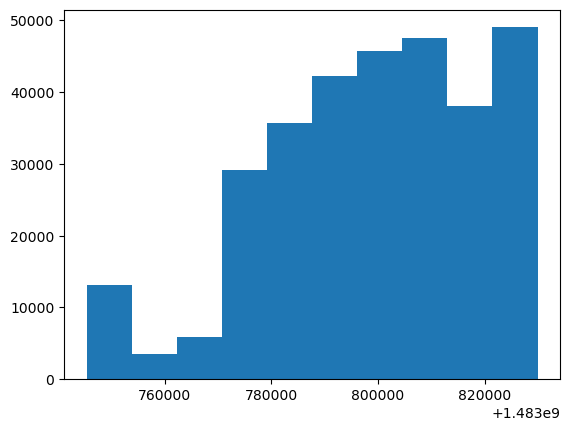

In [12]:
import matplotlib.pyplot as plt
tt = interaction_matrix.timestamps.values[int(0.999 * len(interaction_matrix.timestamps.values))]
plt.hist(interaction_matrix.timestamps_lte(tt).timestamps.values)

In [13]:
interaction_matrix.timestamps.values
t_80 = interaction_matrix.timestamps.values[int(0.8 * len(interaction_matrix.timestamps.values))]
t_validate_80 = interaction_matrix.timestamps.values[int(0.8 * 0.8 * len(interaction_matrix.timestamps.values))]
print(t_80, t_validate_80)

1483818916 1483808390


In [ ]:
scenario = TimedLastItemPrediction(t = t_80, t_validation = t_validate_80, validation=True)
scenario.split(interaction_matrix)

## Experimental RecPack Pipeline

In [15]:
pipeline_builder = PipelineBuilder()
ok = (scenario._validation_data_in, scenario._validation_data_out)
pipeline_builder.set_data_from_scenario(scenario)


# Add the baseline algorithms
#pipeline_builder.add_algorithm('ItemKNN', grid={'K': [100, 200, 400, 800]})
#pipeline_builder.add_algorithm('EASE', grid={'l2': [10, 100, 1000], 'alpha': [0, 0.1, 0.5]})

# Add our LightGCN algorithm
pipeline_builder.add_algorithm(
    'NGCFAlgorithm',
    grid={
        'learning_rate': [0.1, 0.01, 0.001],
        'dropout': [0.0, 0.1, 0.2]
    },
    params={
        'max_epochs': 5,
        'batch_size': 1024,
        'n_layers': 3,
        'stop_early': True,
        'max_iter_no_change': 5,
        'min_improvement': 0.01,
        'save_best_to_file': True,
        'keep_last': True
    }
)

# Add NDCG, Recall, and HR metrics to be evaluated at 10, 20, and 50
pipeline_builder.add_metric('NDCGK', [10, 20, 50])
pipeline_builder.add_metric('RecallK', [10, 20, 50])
pipeline_builder.add_metric('HitK', [10, 20, 50])

# Set the optimisation metric
pipeline_builder.set_optimisation_metric('RecallK', 20)

# Construct pipeline
pipeline = pipeline_builder.build()

# Debugging: Output the shape of the training data
#print(f"Training data shape: {im.shape}")

# Run pipeline, will first do optimisation, and then evaluation
pipeline.run()

/opt/conda/lib/python3.11/site-packages/recpack/pipelines/pipeline_builder.py:145: UserWarning: Grid parameter for add_algorithm function will be deprecated in favour of optimisation_info.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 10:47:46,003 - base - recpack - INFO - Processed epoch 0 in 2.49 s.Batch Training Loss = 0.6004
2024-08-06 10:49:58,976 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4344428940735167, which is better than previous iterations.
2024-08-06 10:49:58,983 - base - recpack - INFO - Evaluation at end of 0 took 132.98 s.
2024-08-06 10:50:00,181 - base - recpack - INFO - Processed epoch 1 in 1.20 s.Batch Training Loss = 0.2298
2024-08-06 10:52:12,996 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.3729042338644781, which is better than previous iterations.
2024-08-06 10:52:13,003 - base - recpack - INFO - Evaluation at end of 1 took 132.82 s.
2024-08-06 10:52:14,069 - base - recpack - INFO - Processed epoch 2 in 1.06 s.Batch Training Loss = nan
2024-08-06 10:54:27,612 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.3831733374276109, which is worse than previous iterations.
2024-08-06 10:54:27,618 - base - recpack - IN

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 11:01:29,183 - base - recpack - INFO - Processed epoch 0 in 1.21 s.Batch Training Loss = 0.3375
2024-08-06 11:03:40,464 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.41062112641876314, which is better than previous iterations.
2024-08-06 11:03:40,471 - base - recpack - INFO - Evaluation at end of 0 took 131.29 s.
2024-08-06 11:03:41,546 - base - recpack - INFO - Processed epoch 1 in 1.07 s.Batch Training Loss = 0.1620
2024-08-06 11:05:52,817 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4011712454505107, which is worse than previous iterations.
2024-08-06 11:05:52,825 - base - recpack - INFO - Evaluation at end of 1 took 131.28 s.
2024-08-06 11:05:53,912 - base - recpack - INFO - Processed epoch 2 in 1.09 s.Batch Training Loss = 0.0954
2024-08-06 11:08:04,473 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.39668251013296857, which is better than previous iterations.
2024-08-06 11:08:04,480 - base - recpack

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 11:15:12,031 - base - recpack - INFO - Processed epoch 0 in 2.40 s.Batch Training Loss = 0.2656
2024-08-06 11:17:26,204 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5224627418785595, which is better than previous iterations.
2024-08-06 11:17:26,211 - base - recpack - INFO - Evaluation at end of 0 took 134.18 s.
2024-08-06 11:17:28,129 - base - recpack - INFO - Processed epoch 1 in 1.92 s.Batch Training Loss = 0.0630
2024-08-06 11:19:41,913 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5233028990296489, which is worse than previous iterations.
2024-08-06 11:19:41,920 - base - recpack - INFO - Evaluation at end of 1 took 133.79 s.
2024-08-06 11:19:44,349 - base - recpack - INFO - Processed epoch 2 in 2.43 s.Batch Training Loss = 0.0557
2024-08-06 11:22:05,024 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5026179520977565, which is better than previous iterations.
2024-08-06 11:22:05,032 - base - recpack -

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 11:29:32,455 - base - recpack - INFO - Processed epoch 0 in 1.16 s.Batch Training Loss = 0.4670
2024-08-06 11:31:41,825 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6288682634425151, which is better than previous iterations.
2024-08-06 11:31:41,833 - base - recpack - INFO - Evaluation at end of 0 took 129.38 s.
2024-08-06 11:31:42,966 - base - recpack - INFO - Processed epoch 1 in 1.13 s.Batch Training Loss = nan
2024-08-06 11:33:57,922 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.6305560675964088, which is worse than previous iterations.
2024-08-06 11:33:57,930 - base - recpack - INFO - Evaluation at end of 1 took 134.96 s.
2024-08-06 11:33:59,068 - base - recpack - INFO - Processed epoch 2 in 1.14 s.Batch Training Loss = 0.0704
2024-08-06 11:36:12,416 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.7784923683177866, which is worse than previous iterations.
2024-08-06 11:36:12,424 - base - recpack - INF

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 11:43:31,020 - base - recpack - INFO - Processed epoch 0 in 1.28 s.Batch Training Loss = 0.3746
2024-08-06 11:45:50,733 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.44857276576015764, which is better than previous iterations.
2024-08-06 11:45:50,741 - base - recpack - INFO - Evaluation at end of 0 took 139.72 s.
2024-08-06 11:45:51,874 - base - recpack - INFO - Processed epoch 1 in 1.13 s.Batch Training Loss = 0.1057
2024-08-06 11:48:08,737 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.445224185661371, which is worse than previous iterations.
2024-08-06 11:48:08,745 - base - recpack - INFO - Evaluation at end of 1 took 136.87 s.
2024-08-06 11:48:09,872 - base - recpack - INFO - Processed epoch 2 in 1.13 s.Batch Training Loss = 0.0082
2024-08-06 11:50:23,325 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4375894834601412, which is better than previous iterations.
2024-08-06 11:50:23,332 - base - recpack -

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 11:57:35,090 - base - recpack - INFO - Processed epoch 0 in 2.39 s.Batch Training Loss = 0.2863
2024-08-06 11:59:42,376 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5433174655462706, which is better than previous iterations.
2024-08-06 11:59:42,384 - base - recpack - INFO - Evaluation at end of 0 took 127.29 s.
2024-08-06 11:59:44,689 - base - recpack - INFO - Processed epoch 1 in 2.30 s.Batch Training Loss = 0.0623
2024-08-06 12:01:51,210 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5518306171394853, which is worse than previous iterations.
2024-08-06 12:01:51,218 - base - recpack - INFO - Evaluation at end of 1 took 126.53 s.
2024-08-06 12:01:53,861 - base - recpack - INFO - Processed epoch 2 in 2.64 s.Batch Training Loss = 0.0577
2024-08-06 12:04:00,741 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.551443862218975, which is worse than previous iterations.
2024-08-06 12:04:00,748 - base - recpack - I

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 12:11:08,513 - base - recpack - INFO - Processed epoch 0 in 1.41 s.Batch Training Loss = 0.4871
2024-08-06 12:13:15,330 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.3797126803001846, which is better than previous iterations.
2024-08-06 12:13:15,338 - base - recpack - INFO - Evaluation at end of 0 took 126.82 s.
2024-08-06 12:13:16,465 - base - recpack - INFO - Processed epoch 1 in 1.13 s.Batch Training Loss = nan
2024-08-06 12:15:25,920 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.37954585603619234, which is worse than previous iterations.
2024-08-06 12:15:25,928 - base - recpack - INFO - Evaluation at end of 1 took 129.46 s.
2024-08-06 12:15:27,050 - base - recpack - INFO - Processed epoch 2 in 1.12 s.Batch Training Loss = nan
2024-08-06 12:17:33,741 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4007314004447808, which is worse than previous iterations.
2024-08-06 12:17:33,748 - base - recpack - INFO 

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 12:24:28,798 - base - recpack - INFO - Processed epoch 0 in 1.26 s.Batch Training Loss = 0.3936
2024-08-06 12:26:38,724 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5250940973110417, which is better than previous iterations.
2024-08-06 12:26:38,731 - base - recpack - INFO - Evaluation at end of 0 took 129.93 s.
2024-08-06 12:26:39,946 - base - recpack - INFO - Processed epoch 1 in 1.21 s.Batch Training Loss = 0.5396
2024-08-06 12:28:48,127 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5140043566406504, which is better than previous iterations.
2024-08-06 12:28:48,135 - base - recpack - INFO - Evaluation at end of 1 took 128.19 s.
2024-08-06 12:28:49,436 - base - recpack - INFO - Processed epoch 2 in 1.30 s.Batch Training Loss = 0.1589
2024-08-06 12:30:58,319 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5089674343109236, which is worse than previous iterations.
2024-08-06 12:30:58,328 - base - recpack -

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 12:38:06,379 - base - recpack - INFO - Processed epoch 0 in 2.80 s.Batch Training Loss = 0.2878
2024-08-06 12:40:13,548 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5544957359551963, which is better than previous iterations.
2024-08-06 12:40:13,556 - base - recpack - INFO - Evaluation at end of 0 took 127.18 s.
2024-08-06 12:40:15,956 - base - recpack - INFO - Processed epoch 1 in 2.40 s.Batch Training Loss = 0.0657
2024-08-06 12:42:26,936 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5566093921114436, which is worse than previous iterations.
2024-08-06 12:42:26,945 - base - recpack - INFO - Evaluation at end of 1 took 130.99 s.
2024-08-06 12:42:29,773 - base - recpack - INFO - Processed epoch 2 in 2.83 s.Batch Training Loss = 0.0569
2024-08-06 12:44:41,088 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.5557080567136162, which is worse than previous iterations.
2024-08-06 12:44:41,097 - base - recpack - 

/tmp/ipykernel_48875/1947374894.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_indices = torch.tensor(user_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_item_indices = torch.tensor(pos_item_indices).to(self.device)
/tmp/ipykernel_48875/1947374894.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neg_item_indices = torch.tensor(neg_item_indices).to(self.device).squeeze()


2024-08-06 12:51:53,035 - base - recpack - INFO - Processed epoch 0 in 1.20 s.Batch Training Loss = 0.3960
2024-08-06 12:54:04,171 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4659773360465761, which is better than previous iterations.
2024-08-06 12:54:04,179 - base - recpack - INFO - Evaluation at end of 0 took 131.14 s.
2024-08-06 12:54:05,536 - base - recpack - INFO - Processed epoch 1 in 1.36 s.Batch Training Loss = 0.2629
2024-08-06 12:56:15,875 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4325002240903696, which is better than previous iterations.
2024-08-06 12:56:15,882 - base - recpack - INFO - Evaluation at end of 1 took 130.35 s.
2024-08-06 12:56:17,241 - base - recpack - INFO - Processed epoch 2 in 1.36 s.Batch Training Loss = 0.1193
2024-08-06 12:58:27,798 - stopping_criterion - recpack - INFO - StoppingCriterion has value 0.4210638232697017, which is better than previous iterations.
2024-08-06 12:58:27,805 - base - recpack 

## Results

In [16]:
pipeline.get_metrics()

,NDCGK_10,NDCGK_20,NDCGK_50,RecallK_10,RecallK_20,RecallK_50,HitK_10,HitK_20,HitK_50
"NGCFAlgorithm(batch_size=1024,dropout=0.0,embedding_dim=64,grad_clip=1.0,keep_last=True,learning_rate=0.01,max_epochs=5,max_iter_no_change=5,message_dropout=0.0,min_improvement=0.01,n_layers=3,node_dropout=0.0,predict_topK=None,save_best_to_file=True,seed=2034669135,stop_early=True,stopping_criterion=<recpack.algorithms.stopping_criterion.StoppingCriterion object at 0x7f934ac0cf90>,validation_sample_size=None)",0.023922,0.042137,0.069392,0.062043,0.133601,0.269141,0.062043,0.133601,0.269141
